In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/ML/Thesis/Dataset/AU-PEMal-2025-V2.csv')

In [4]:
df['Category'].unique()

array(['Benign', 'Ransomware', 'RAT', 'Trojan', 'Stealer'], dtype=object)

In [5]:
df.head()

,sha1,processes_malicious,processes_monitored,processes_suspicious,total_procsses,files_malicious,files_suspicious,files_unknown,files_text,registry_total,...,text_PointerToRawData,BaseOfCode,BaseOfData,ImageBase,Checksum,SectionAlignment,SizeOfHeaders,Class,Category,Family
0,62f4d55a1bb8396e493d7815dc44febed7161535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1024,4096,16384,5368709120,125136,4096,1024,Benign,Benign,Benign
1,ca40945a4e35d48794a5e13aacf16b8ae1caddeb,0.0,2.0,0.0,93.0,0.0,0.0,0.0,0.0,5.0,...,1024,4096,16384,5368709120,5202495,4096,1024,Benign,Benign,Benign
2,6f47b50480bea61ae4dfb75c12582990cc5ce770,0.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,58.0,...,512,8192,16384,4194304,0,8192,512,Benign,Benign,Benign
3,8c3d5b506a8d55f42f4c83ead3e4341255d1acfc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1536,4096,16384,4194304,0,4096,1536,Benign,Benign,Benign
4,0a7d0c68c591db2f197b2169d226bebe6e9bdabe,0.0,1.0,0.0,36.0,0.0,0.0,0.0,0.0,253.0,...,512,8192,0,4194304,0,8192,512,Benign,Benign,Benign


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.shape

(21703, 39)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21703 entries, 0 to 21702
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sha1                     21703 non-null  object 
 1   processes_malicious      21703 non-null  float64
 2   processes_monitored      21703 non-null  float64
 3   processes_suspicious     21703 non-null  float64
 4   total_procsses           21703 non-null  float64
 5   files_malicious          21703 non-null  float64
 6   files_suspicious         21703 non-null  float64
 7   files_unknown            21703 non-null  float64
 8   files_text               21703 non-null  float64
 9   registry_total           21703 non-null  float64
 10  registry_read            21703 non-null  float64
 11  registry_write           21703 non-null  float64
 12  registry_delete          21703 non-null  float64
 13  network_dns              21703 non-null  float64
 14  network_http          

In [9]:
df = df.drop(['sha1','Class', 'Family'], axis=1)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns =[ 'Category']
df = pd.DataFrame(df)

In [10]:
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [11]:
df.isnull().sum()

,0
processes_malicious,0
processes_monitored,0
processes_suspicious,0
total_procsses,0
files_malicious,0
files_suspicious,0
files_unknown,0
files_text,0
registry_total,0
registry_read,0


##Outliers ##

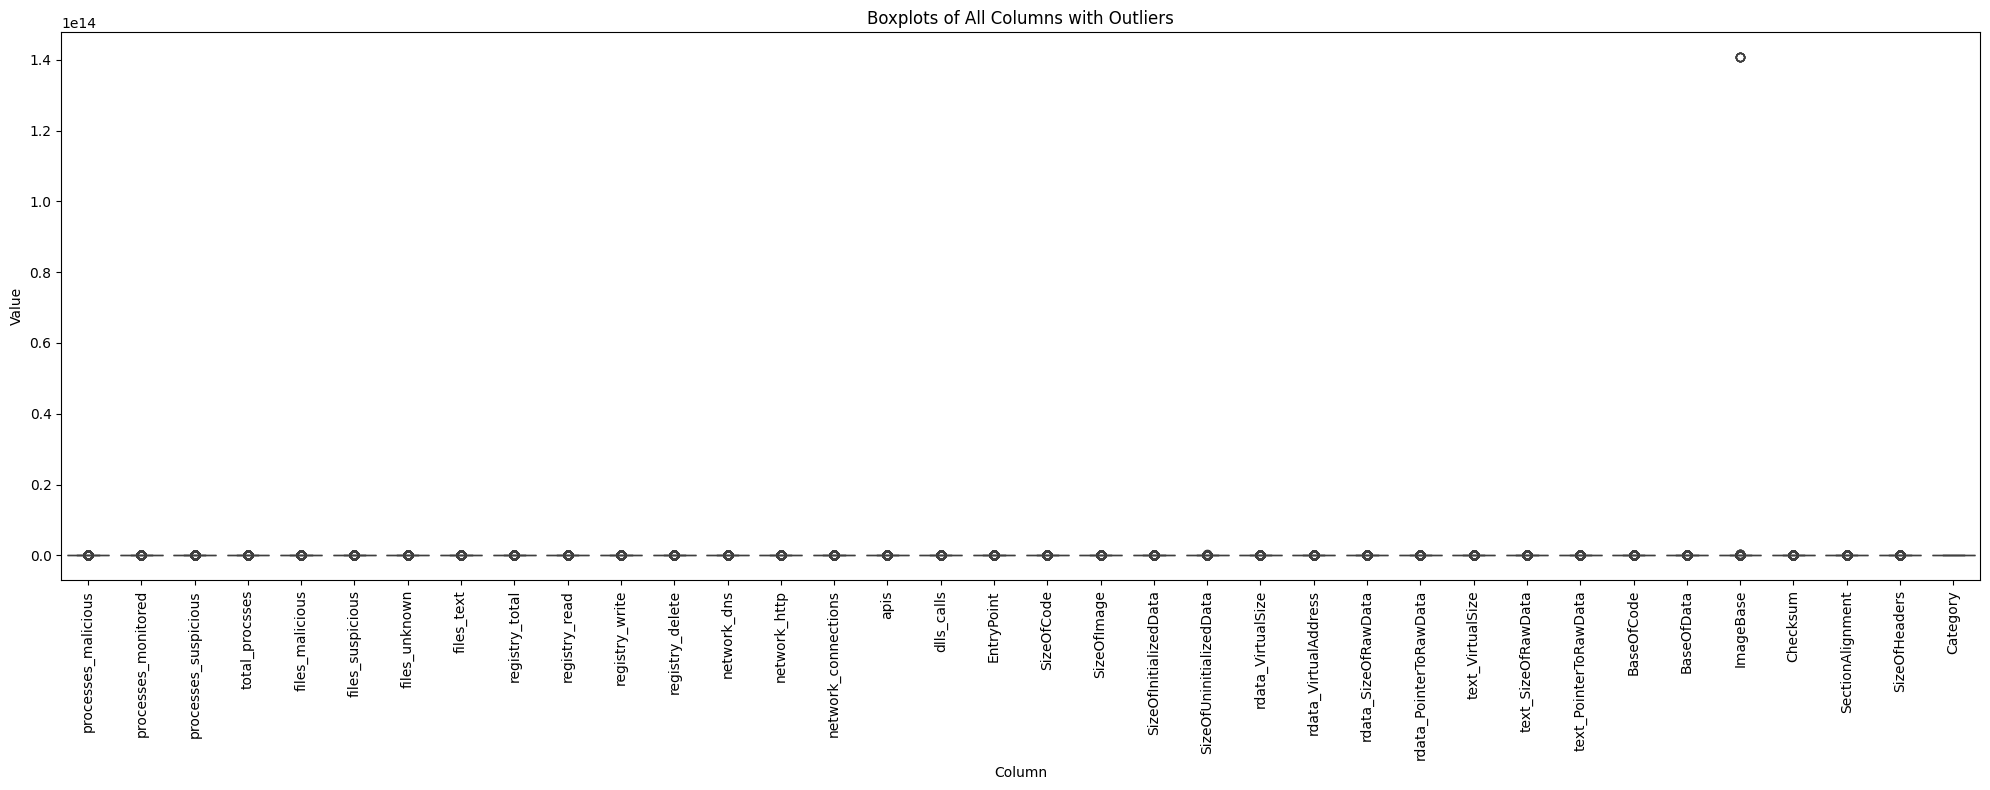

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


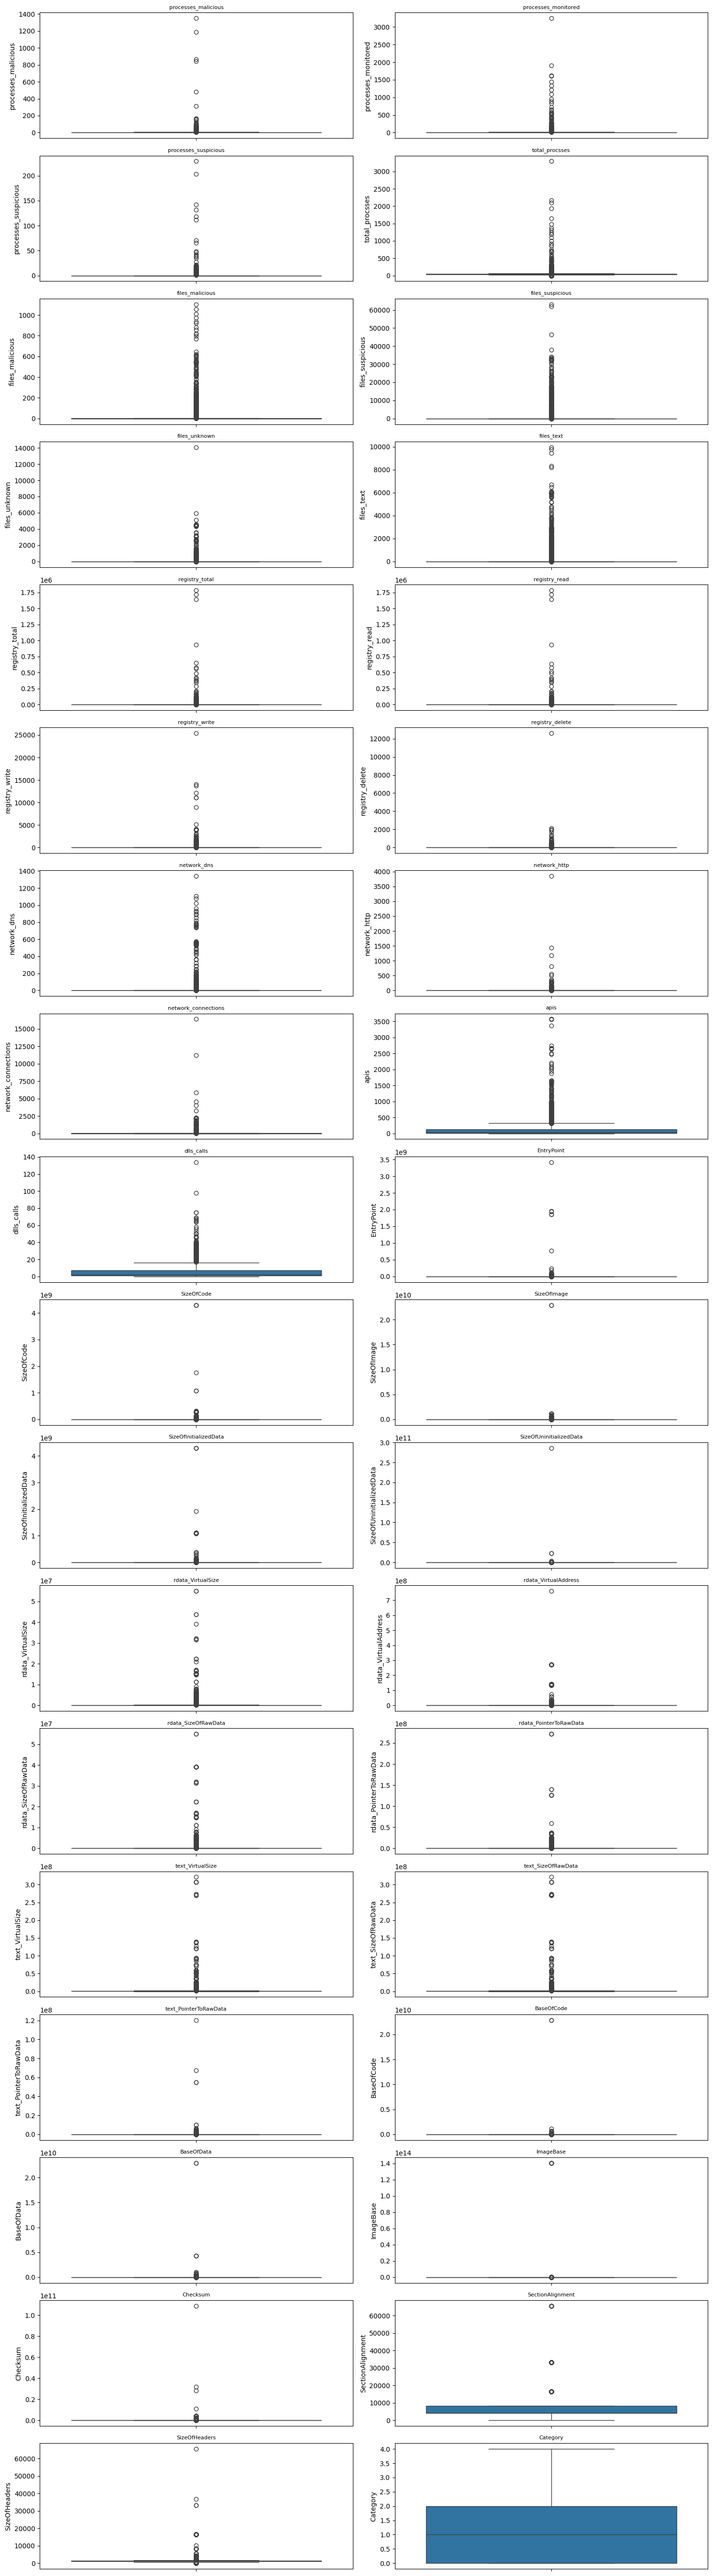

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

n_cols = 2
n_rows = math.ceil(len(df.columns) / n_cols)

plt.figure(figsize=(15, n_rows * 3))  # 3 height units per row

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=col, data=df)
    plt.title(col, fontsize=8)

plt.tight_layout()
plt.show()


In [14]:
outliers_per_column = {}
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_per_column[col] = len(outliers)

In [15]:
outliers_per_column

{'processes_malicious': 1307,
 'processes_monitored': 2860,
 'processes_suspicious': 3061,
 'total_procsses': 3914,
 'files_malicious': 3633,
 'files_suspicious': 4614,
 'files_unknown': 4613,
 'files_text': 4157,
 'registry_total': 2935,
 'registry_read': 2919,
 'registry_write': 4460,
 'registry_delete': 2626,
 'network_dns': 3044,
 'network_http': 4231,
 'network_connections': 1537,
 'apis': 1587,
 'dlls_calls': 862,
 'EntryPoint': 2678,
 'SizeOfCode': 2503,
 'SizeOfImage': 3251,
 'SizeOfInitializedData': 3691,
 'SizeOfUninitializedData': 2114,
 'rdata_VirtualSize': 3650,
 'rdata_VirtualAddress': 3115,
 'rdata_SizeOfRawData': 3490,
 'rdata_PointerToRawData': 3039,
 'text_VirtualSize': 2467,
 'text_SizeOfRawData': 2701,
 'text_PointerToRawData': 10388,
 'BaseOfCode': 3034,
 'BaseOfData': 2757,
 'ImageBase': 4326,
 'Checksum': 3618,
 'SectionAlignment': 2084,
 'SizeOfHeaders': 8933,
 'Category': 0}

In [16]:
#Cap Outliers (Winsorize / Clipping Approach)
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                 np.where(df[column] > upper, upper, df[column]))
    return df

# Apply to columns with outliers
for col, count in outliers_per_column.items():
    if count > 0:
        df = cap_outliers_iqr(df, col)

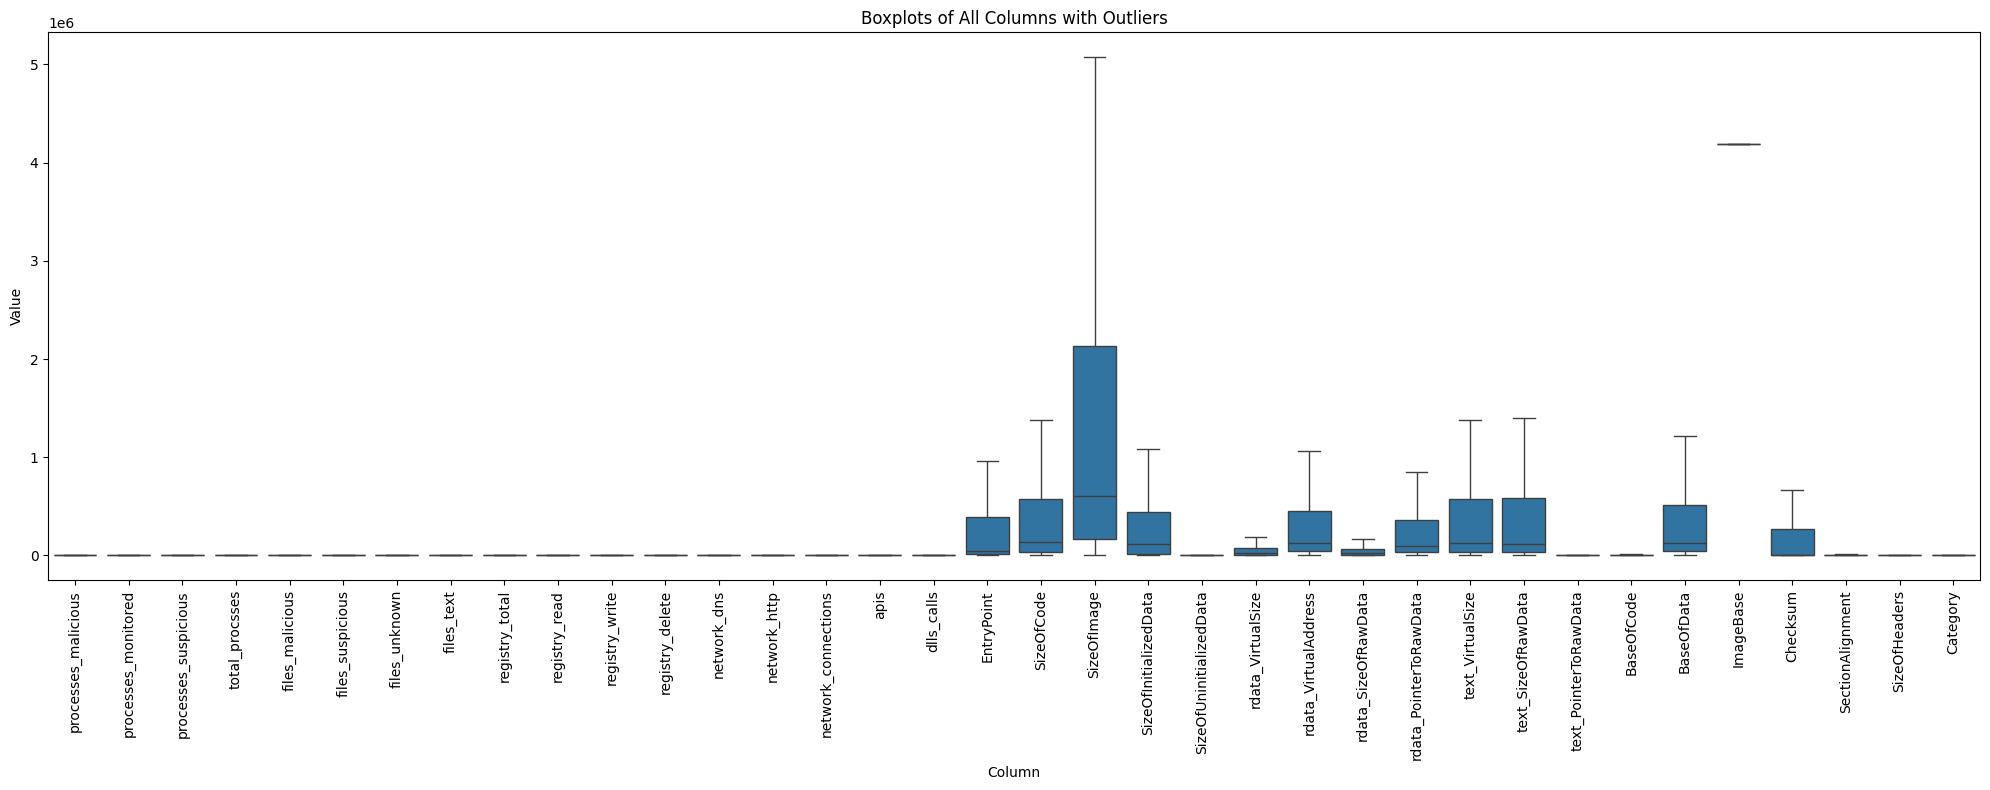

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


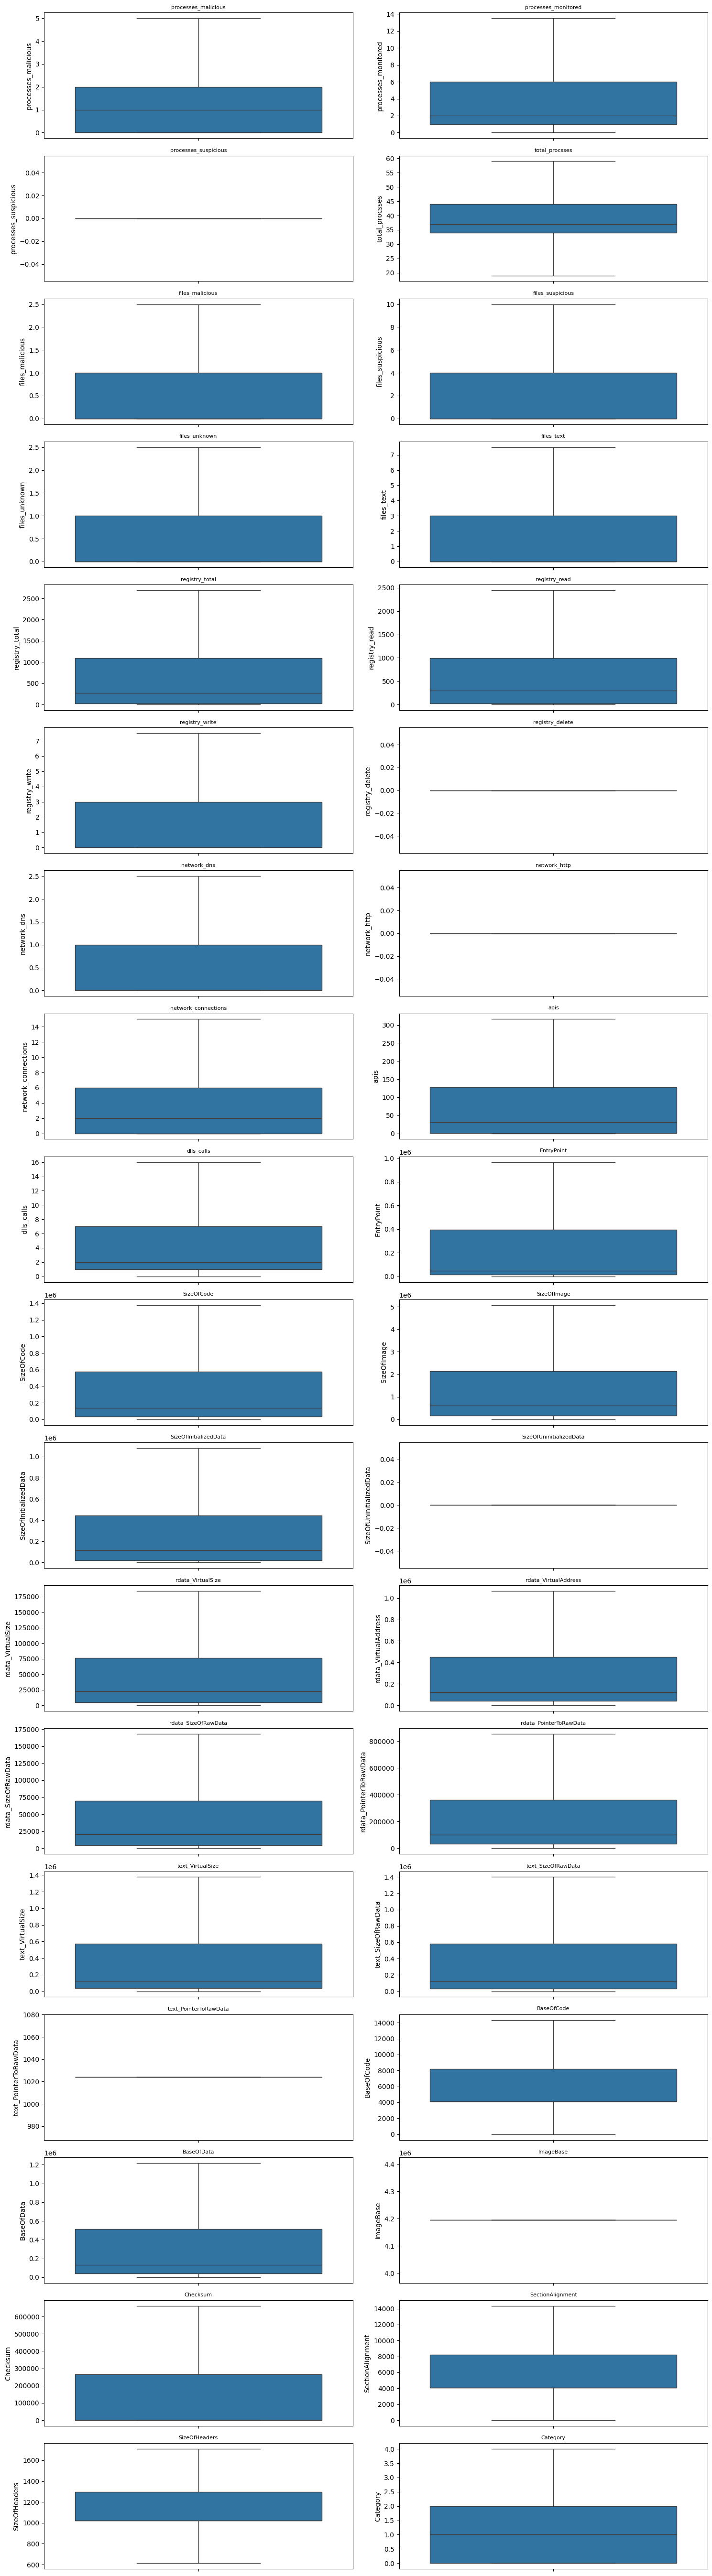

In [ ]:
n_cols = 2
n_rows = math.ceil(len(df.columns) / n_cols)

plt.figure(figsize=(15, n_rows * 3))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=col, data=df)
    plt.title(col, fontsize=8)

plt.tight_layout()
plt.show()


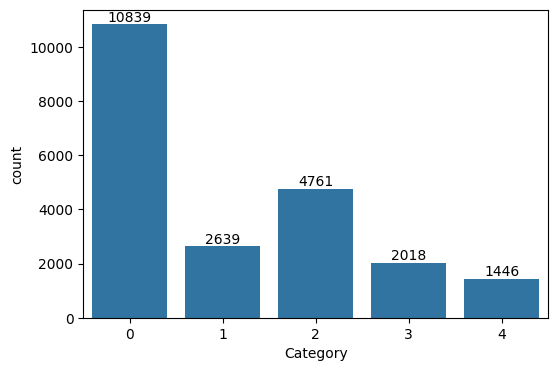

In [18]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Category',data=df)
for i in ax.containers:
    ax.bar_label(i,)

<h3>Normalization</h3>

In [19]:
from sklearn.preprocessing import StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = df.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [20]:
# Separate features and labels
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Class labels
X.shape

(21703, 35)

In [21]:
y.shape

(21703,)

<h3>LSTM with 20 Epochs Implementation</h3>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        83,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,629 (541.52 KB)

 Trainable params: 138,245 (540.02 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6863 - loss: 0.8586 - val_accuracy: 0.8782 - val_loss: 0.8755
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8704 - loss: 0.3775 - val_accuracy: 0.9110 - val_loss: 0.2751
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8940 - loss: 0.2980 - val_accuracy: 0.9243 - val_loss: 0.2182
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9051 - loss: 0.2823 - val_accuracy: 0.9289 - val_loss: 0.2007
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9146 - loss: 0.2583 - val_accuracy: 0.9303 - val_loss: 0.1950
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9185 - loss: 0.2352 - val_accuracy: 0.9349 - val_loss: 0.1840
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9224 - loss: 0.2211 - val_accuracy: 0.9375 - val_loss: 0.1772
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9300 - loss: 0.2024 - val_accuracy:

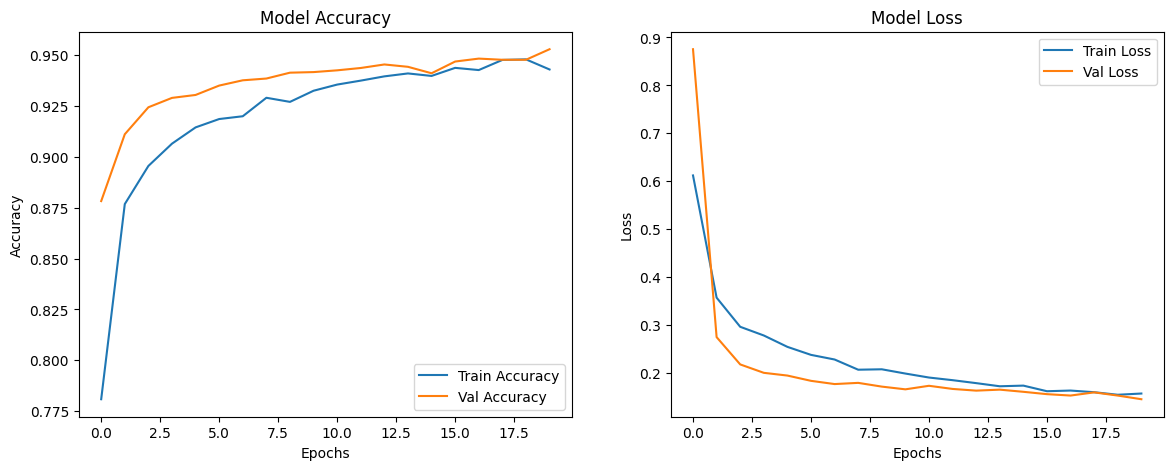

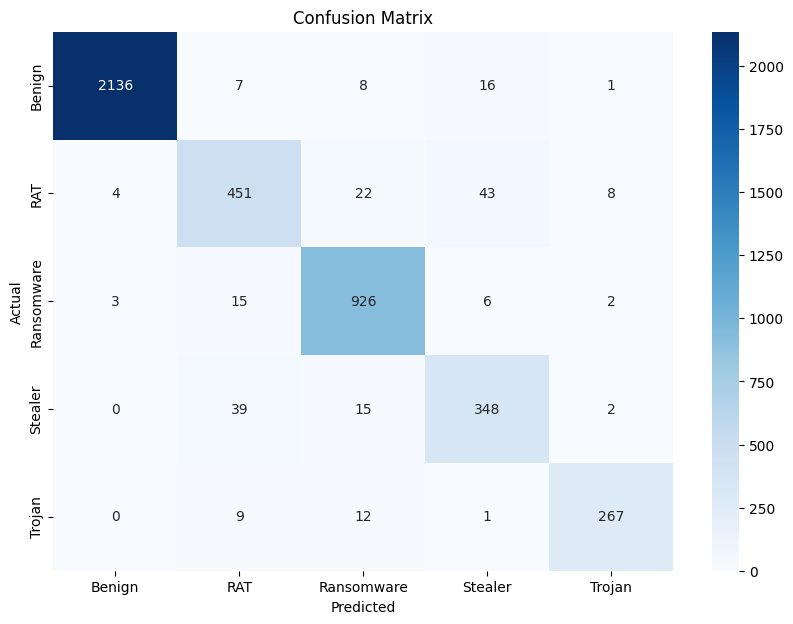

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

timesteps = 1   # since features are static, treat them as 1 timestep
X = np.expand_dims(X, axis=1)   # reshape to (samples, 1, features)

# Encode labels (for multiclass)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_encoded = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# =====================================
# 🔹 Define LSTM model
# =====================================
model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

# =====================================
# 🔹 Train Model
# =====================================
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)

# =====================================
# 🔹 Evaluate Model
# =====================================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print("📊 Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
# Define your two class names
class_names = ["Benign", "RAT", "Ransomware", "Stealer", "Trojan"]

print("\nClassification Report:\n", classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

# =====================================
# 🔹 Training Accuracy/Loss Graphs
# =====================================
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/lstm-category-accuracy-loss.pdf")   # <-- save as PDF
plt.show()

# =====================================
# 🔹 Confusion Matrix
# =====================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/lstm-category-confusion.pdf")   # <-- save as PDF
plt.show()
